# Summary

## Task

To explore dependency parsing for sentences so that word level graphs can be constructed for the problem of classification

1. Explore how dependency parsing works
2. Tokenize sentences and give them to the dependency parser
3. Obtain the relationships and check them
4. Convert the dependency graphs from the parser into the graphs that can be used for GCN
5. Explore GCN and try to build graphs from the parsed dependency graphs
6. Perform graph level classification
7. Check performance
8. Refine the various layers and hyperparameters in the process
9. Check final performance
10. Do interpreation manually on some selected examples
11. Implement edge masking to get the minimum subgraph
12. Performe automatic interpretation of the graphs to determine the most important terms/relationships for each sentence

## Method

* For dependency parsing, we will try to use the tools from the stanford nlp group.
* The *[CoreNLP](https://github.com/stanfordnlp/CoreNLP)* library is important as it contains many of the tools needed to performe dependency parsing
* The *[stanza](https://github.com/stanfordnlp/stanza)* library offers a wrapped version of CoreNLP that works directly with Python
* Visualization of the graphs can be done using *[networkx](https://github.com/networkx/networkx)*
* For GCN and word-level graphs we will primarily look at the ideas in this *[tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html)*
* We will try to use the *[spectral](https://github.com/danielegrattarola/spektral/)* library to implement the graphs convolution and attention 
* *[Link](https://universaldependencies.org/u/dep/)* to explaination of dependency relations.

## Dataset

The dataset is still IMDB review but we may expand later on

## Results

Fill in later

## Conclusion

Fill in at the end

# Code

## Basic Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
import stanza

In [13]:
stanza.download('en')

2022-05-23 21:27:58 INFO: Downloading default packages for language: en (English)...


2022-05-23 21:31:24 INFO: Finished downloading models and saved to /Users/zeyuyang/stanza_resources.


In [35]:
import networkx as nx

## Part 1: Dependency Parsing

### Testing 

In [11]:
sampleSentence = "There is nothing wrong with Apple's new M1 Max Chip, everything works so well!"

In [12]:
sampleSentence

"There is nothing wrong with Apple's new M1 Max Chip, everything works so well!"

In [23]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse')

2022-05-23 21:41:54 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-05-23 21:41:55 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-05-23 21:41:55 INFO: Use device: cpu
2022-05-23 21:41:55 INFO: Loading: tokenize
2022-05-23 21:41:55 INFO: Loading: pos
2022-05-23 21:41:55 INFO: Loading: lemma
2022-05-23 21:41:55 INFO: Loading: depparse
2022-05-23 21:41:55 INFO: Done loading processors!


In [25]:
doc = nlp(sampleSentence)

In [67]:
doc

[
  [
    {
      "id": 1,
      "text": "There",
      "lemma": "there",
      "upos": "PRON",
      "xpos": "EX",
      "head": 2,
      "deprel": "expl",
      "start_char": 0,
      "end_char": 5
    },
    {
      "id": 2,
      "text": "is",
      "lemma": "be",
      "upos": "VERB",
      "xpos": "VBZ",
      "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "start_char": 6,
      "end_char": 8
    },
    {
      "id": 3,
      "text": "nothing",
      "lemma": "nothing",
      "upos": "PRON",
      "xpos": "NN",
      "feats": "Number=Sing",
      "head": 2,
      "deprel": "nsubj",
      "start_char": 9,
      "end_char": 16
    },
    {
      "id": 4,
      "text": "wrong",
      "lemma": "wrong",
      "upos": "ADJ",
      "xpos": "JJ",
      "feats": "Degree=Pos",
      "head": 3,
      "deprel": "amod",
      "start_char": 17,
      "end_char": 22
    },
    {
      "id": 5,
      "text": "with",
      "lemma":

In [27]:
doc.sentences[0].print_dependencies()

('There', 2, 'expl')
('is', 0, 'root')
('nothing', 2, 'nsubj')
('wrong', 3, 'amod')
('with', 10, 'case')
('Apple', 10, 'nmod:poss')
("'s", 6, 'case')
('new', 10, 'amod')
('M1', 10, 'compound')
('Max', 3, 'nmod')
('Chip', 10, 'flat')
(',', 14, 'punct')
('everything', 14, 'nsubj')
('works', 2, 'parataxis')
('so', 16, 'advmod')
('well', 14, 'advmod')
('!', 2, 'punct')


In [29]:
print ("{:<15} | {:<10} | {:<15} ".format('Token', 'Relation', 'Head'))
print ("-" * 50)
# Convert sentence object to dictionary  
sent_dict = doc.sentences[0].to_dict()

# iterate to print the token, relation and head
for word in sent_dict:
  print ("{:<15} | {:<10} | {:<15} "
         .format(str(word['text']),str(word['deprel']), str(sent_dict[word['head']-1]['text'] if word['head'] > 0 else 'ROOT')))


Token           | Relation   | Head            
--------------------------------------------------
There           | expl       | is              
is              | root       | ROOT            
nothing         | nsubj      | is              
wrong           | amod       | nothing         
with            | case       | Max             
Apple           | nmod:poss  | Max             
's              | case       | Apple           
new             | amod       | Max             
M1              | compound   | Max             
Max             | nmod       | nothing         
Chip            | flat       | Max             
,               | punct      | works           
everything      | nsubj      | works           
works           | parataxis  | is              
so              | advmod     | well            
well            | advmod     | works           
!               | punct      | is              


In [120]:
G = nx.DiGraph()
G.add_nodes_from(range(1, len(sent_dict) + 1))

for edge in sent_dict:
    if edge['head']:
        G.add_edge(edge['head'], edge['id'])
               
words = [word['text'] for word in sent_dict]
labels = {index + 1: words[index] + ":" + str(index + 1) for index in range(len(words))}


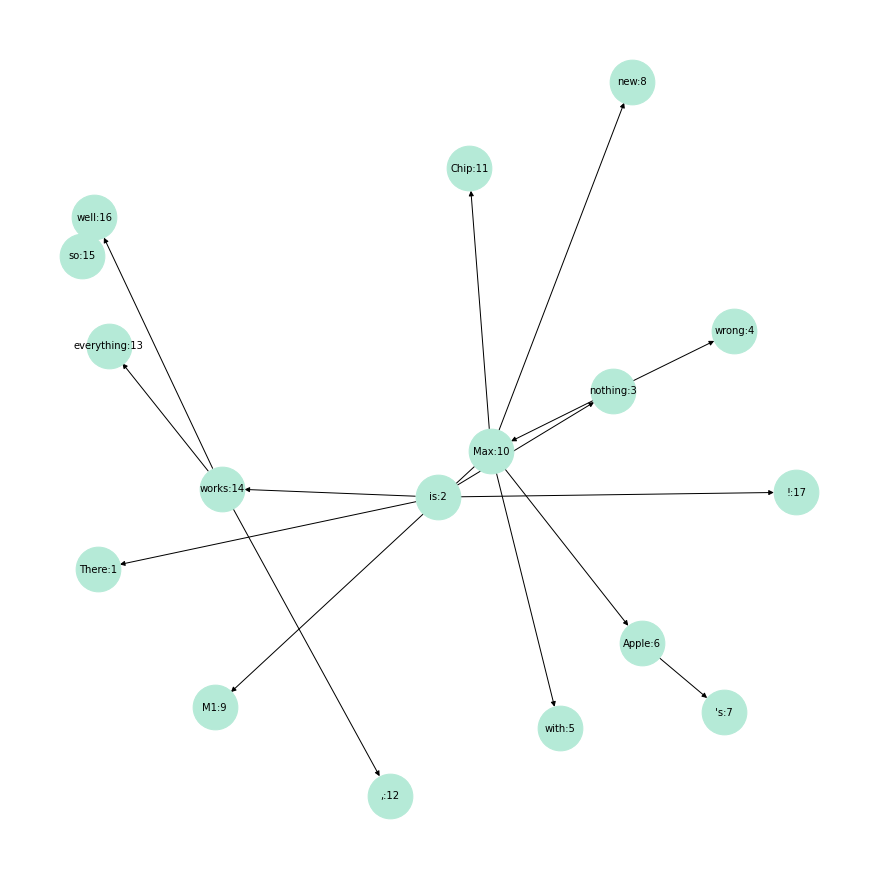

In [121]:
plt.figure(3,figsize=(12,12)) 

nx.draw(G, with_labels=True, labels=labels, node_size=2000, node_color='#B5EAD7', font_size=10)

In [122]:
G.edges

OutEdgeView([(2, 1), (2, 3), (2, 14), (2, 17), (3, 4), (3, 10), (6, 7), (10, 5), (10, 6), (10, 8), (10, 9), (10, 11), (14, 12), (14, 13), (14, 16), (16, 15)])

In [123]:
G.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17))

In [19]:
sampleSentence2 = "<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

In [22]:
sampleSentence2

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [20]:
doc2 = nlp(sampleSentence2)

In [21]:
doc2.sentences[0].print_dependencies()

('<', 2, 'punct')
('START', 10, 'reparandum')
('>', 2, 'punct')
('this', 5, 'det')
('film', 10, 'nsubj')
('was', 10, 'cop')
('just', 10, 'advmod')
('brilliant', 10, 'amod')
('casting', 10, 'compound')
('location', 0, 'root')
('scenery', 13, 'compound')
('story', 13, 'compound')
('direction', 10, 'conj')
('everyone', 17, 'nsubj')
("'s", 17, 'aux')
('really', 17, 'advmod')
('suited', 13, 'parataxis')
('the', 19, 'det')
('part', 17, 'obj')
('they', 21, 'nsubj')
('played', 19, 'acl:relcl')
('and', 26, 'cc')
('you', 26, 'nsubj')
('could', 26, 'aux')
('just', 26, 'advmod')
('imagine', 17, 'conj')
('being', 28, 'cop')
('there', 26, 'advmod')
('robert', 26, 'obj')
('<', 31, 'punct')
('UNK', 36, 'nsubj')
('>', 31, 'punct')
('is', 36, 'cop')
('an', 36, 'det')
('amazing', 36, 'amod')
('actor', 2, 'conj')
('and', 47, 'cc')
('now', 40, 'advmod')
('the', 40, 'det')
('same', 36, 'conj')
('being', 42, 'cop')
('director', 47, 'advcl')
('<', 44, 'punct')
('UNK', 42, 'appos')
('>', 44, 'punct')
('father'